In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Visualiza las 23 columnas
pd.set_option('display.max_columns', 23)
# Carga del CSV en un DataFrame df (usando como delimitador la coma ',')
df = pd.read_csv('train.csv')

In [3]:
# Se renombran las columnas
nombresNuevos = {
                 'id' : 'ID',
                 'titulo' : 'Titulo',
                 'descripcion' : 'Descripcion',
                 'tipodepropiedad' : 'TipoPropiedad',
                 'direccion' : 'Direccion',
                 'ciudad' : 'Ciudad',
                 'provincia' : 'Provincia',
                 'antiguedad' : 'Antiguedad',
                 'habitaciones' : 'CantHabitaciones',
                 'garages' : 'CantGarages',
                 'banos' : 'CantBanos',
                 'metroscubiertos' : 'MetrosCuadradosCubiertos',
                 'metrostotales' : 'MetrosCuadradosTotales',
                 'idzona' : 'IDZona',
                 'lat' : 'Latitud',
                 'lng' : 'Longitud',
                 'fecha' : 'Fecha',
                 'gimnasio' : 'TieneGimnasio',
                 'usosmultiples' : 'TieneUsosMultiples',
                 'piscina' : 'TienePileta',
                 'escuelascercanas' : 'TieneEscuelasCerca',
                 'centroscomercialescercanos' : 'TieneShoppingsCerca',
                 'precio' : 'Precio'
                
}

dfok = df.rename(columns = nombresNuevos)

In [4]:
# Se Reordenan las columnas
nombresEnOrden = [
                 'ID',
                 'Titulo',
                 'TipoPropiedad',
                 'Precio',
                 'Fecha',
                 'Antiguedad',
                 'MetrosCuadradosCubiertos',
                 'MetrosCuadradosTotales',
                 'Descripcion',
                 
                 'CantHabitaciones',
                 'CantGarages',
                 'CantBanos',
               
                 'IDZona',
                 'Direccion',
                 'Ciudad',
                 'Provincia',
                 'Latitud',
                 'Longitud',
                 
                 'TieneGimnasio',
                 'TieneUsosMultiples',
                 'TienePileta',
                 'TieneEscuelasCerca',
                 'TieneShoppingsCerca'
    ]                 

dfok = dfok[nombresEnOrden];

In [5]:
# Análisis de los valores booleanos (y cómo varía el precio respecto a ellos)
# print(df.columns) # Devuelve una serie con lon nombres de las columnas
columnas = ['Ciudad',
            'Provincia',
            'TieneGimnasio',
            'TieneUsosMultiples',
            'TienePileta',
            'TieneEscuelasCerca',
            'TieneShoppingsCerca',
            'Precio'] 

print(columnas)

['Ciudad', 'Provincia', 'TieneGimnasio', 'TieneUsosMultiples', 'TienePileta', 'TieneEscuelasCerca', 'TieneShoppingsCerca', 'Precio']


In [6]:
# Se indica en el Análisis exploratorio de Navent que, de las columnas usadas anterioremente,
# el precio se representa con enteros y las demás columnas son Booleanas

# Se crea un nuevo DataFrame df_abool que copia columnas de interés del DataFrame original
df_abool = dfok[columnas].copy()
memoria_usada = df_abool.memory_usage()
print('Total memoria usada sin cambios de tipos {:.2f}'.format(memoria_usada.sum()/1024/1024), 'MB')
# Se convierten lo tipos de datos a los requeridos
df_abool['TieneGimnasio'] = df_abool['TieneGimnasio'].astype(np.bool)
df_abool['TieneUsosMultiples'] = df_abool['TieneUsosMultiples'].astype(np.bool)
df_abool['TienePileta'] = df_abool['TienePileta'].astype(np.bool)
df_abool['TieneEscuelasCerca'] = df_abool['TieneEscuelasCerca'].astype(np.bool)
df_abool['TieneShoppingsCerca'] = df_abool['TieneShoppingsCerca'].astype(np.bool)

df_abool['Precio'] = df_abool['Precio'].astype(np.uint32)

df_abool['Ciudad'] = df_abool['Ciudad'].astype('category')
df_abool['Provincia'] = df_abool['Provincia'].astype('category')

print('Total memoria usada sin cambios de tipos {0:.2f}'.format(df_abool.memory_usage().sum()/1024/1024), 'MB')

Total memoria usada sin cambios de tipos 14.65 MB
Total memoria usada sin cambios de tipos 2.79 MB


# Análisis de calidad de datos pertinentes

In [7]:
# Análisis de calidad de datos
df_abool.isnull().sum()

Ciudad                 372
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Verifico si hay alguna relación entre los valores nulos de provincias y ciudades

In [8]:
df_abool[(df_abool['Ciudad'].isnull() == True) & (df_abool['Provincia'].isnull() == True)].isnull().sum()

Ciudad                 155
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Los valores de provincias nulos también tienen ciudades nulas. Como se van utilizar estos valores conviene descartarlos.

In [9]:
# Verifico qué ocurre si se eliminan los valores nulos
df_abool.dropna(subset=['Provincia'], inplace=True)
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

In [10]:
df_abool.loc[(df_abool['Provincia'] == 'Colima') & (df_abool['Ciudad'].isnull() == True)]

,Ciudad,Provincia,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Precio


Voy a ver cuánto influyen las cantidades de valores nulos en ciudades por provincia, para ver si es correcto eliminarlas.

In [11]:
# Creo un DataFrame donde solo se almacenen los casos con valores nulos de ciudades
cant_nulos_provincia = df_abool.loc[df_abool['Ciudad'].isnull() == True].copy() # Devuelve un DataFrame
# Elijo quedarme solo con la columna 'provincia' 
cant_nulos_provincia = cant_nulos_provincia['Provincia'] # Devuelve una Serie
# Realizo un conteo para casos nulos por provincia
cant_nulos_provincia = cant_nulos_provincia.value_counts() # Devuelve una Serie
# Paso la Serie a DataFrame
cant_nulos_provincia = cant_nulos_provincia.to_frame()
# Reseteo el índice para tener una columna con el nombre de las provincias
cant_nulos_provincia.reset_index(inplace = True)
# Le cambio el nombre a las provincias
cant_nulos_provincia = cant_nulos_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_nulos'}).copy()
#cant_nulos_provincia
# Ordeno alfabéticamente por nombre de provincia y lo modifico "implace"
cant_nulos_provincia.sort_values(by='Provincia', ascending = True, inplace = True)
cant_nulos_provincia.reset_index(drop = True, inplace=True)

In [12]:
cant_nulos_provincia.head()

,Provincia,cant_nulos
0,Aguascalientes,0
1,Baja California Norte,0
2,Baja California Sur,0
3,Campeche,0
4,Chiapas,0


In [13]:
# Voy a crear un DataFrame para comparar la proporción de ciudades nulas por provincia
# Como adf_abool ya no tiene 'provincia' y 'ciudad' nulos a la vez, uso ese DataFrame
cant_total_provincia = df_abool['Provincia'] # Devuelve una Serie
# Convierto a DataFrame y lo asigo "inplace"
cant_total_provincia = cant_total_provincia.value_counts().to_frame()
cant_total_provincia.reset_index(inplace = True)
cant_total_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_total'}, inplace = True)
cant_total_provincia
cant_total_provincia.sort_values(by = 'Provincia', ascending = True, inplace = True)
cant_total_provincia.reset_index(drop = True, inplace = True)

In [14]:
cant_total_provincia.head()

,Provincia,cant_total
0,Aguascalientes,1753
1,Baja California Norte,3220
2,Baja California Sur,1700
3,Campeche,263
4,Chiapas,1126


# Merge

DataFrame izquierdo ==> cant_nulos_provincia

DataFrame derecho ==> cant_total_provincia

In [15]:
df_joined = pd.merge(cant_nulos_provincia, cant_total_provincia, on='Provincia', how = 'inner')

In [16]:
df_joined = df_joined.loc[df_joined['cant_nulos'] != 0].copy()
df_joined.reset_index(drop = True, inplace = True)
# Ya se tiene un DataFrame para calcular la proporción de los valores nulos en los totales (por provincia)
df_joined

,Provincia,cant_nulos,cant_total
0,Chihuahua,46,4590
1,Distrito Federal,20,58790
2,Durango,1,2275
3,Edo. de México,18,41607
4,Guanajuato,3,2860
5,Guerrero,3,2678
6,Jalisco,21,21238
7,Morelos,2,7337
8,Nuevo León,9,15324
9,Oaxaca,3,711


## Agrego columna de proporciones

In [17]:
df_joined['propor_nulos [%]'] = df_joined['cant_nulos'] / df_joined['cant_total'] * 100
# Se redondea a dos decimales
df_joined['propor_nulos [%]'] = df_joined['propor_nulos [%]'].round(2)
df_joined

,Provincia,cant_nulos,cant_total,propor_nulos [%]
0,Chihuahua,46,4590,1.00
1,Distrito Federal,20,58790,0.03
2,Durango,1,2275,0.04
3,Edo. de México,18,41607,0.04
4,Guanajuato,3,2860,0.10
5,Guerrero,3,2678,0.11
6,Jalisco,21,21238,0.10
7,Morelos,2,7337,0.03
8,Nuevo León,9,15324,0.06
9,Oaxaca,3,711,0.42


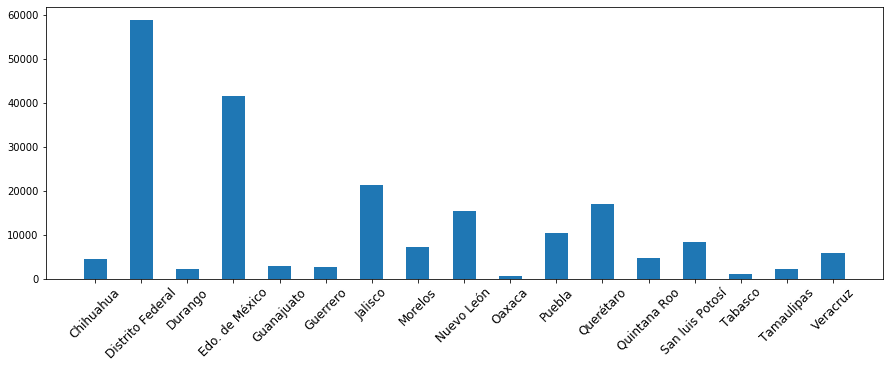

In [18]:
### Visualización de proporción de datos nulos. PUEDE NO SER NECESARIO
plt.figure(figsize = (15,5))

prov_tot = df_joined['cant_total']
prov_nul = df_joined['cant_nulos']
ancho = 0.5
ind = df_joined['Provincia']
p1 = plt.bar(ind, prov_tot, ancho)
p2 = plt.bar(ind, prov_nul, ancho)
plt.xticks(rotation = 45, fontsize = 12)

plt.show()

Se ve que no representan más del 1% de los casos totales. Enonces se pueden eliminar.

In [19]:
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

In [20]:
df_abool.shape

(239845, 8)

In [21]:
df_abool.dropna(inplace = True)
df_abool.isnull().sum()

Ciudad                 0
Provincia              0
TieneGimnasio          0
TieneUsosMultiples     0
TienePileta            0
TieneEscuelasCerca     0
TieneShoppingsCerca    0
Precio                 0
dtype: int64

In [22]:
df_abool.shape

(239628, 8)

Media del precio de las propiedades con gimnasio $ 3812891
Media del precio de las propiedades sin gimnasio $ 2445053



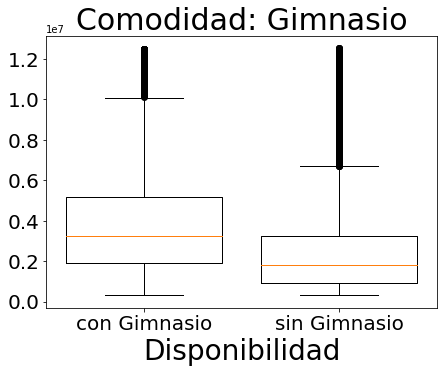

In [23]:
# Comparación directa de los servicios y disponibilidades de las propiedades

print('Media del precio de las propiedades con gimnasio $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin gimnasio $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio'].mean()))

fig_1 = plt.figure(1, figsize = (7,5))
sub_fig = fig_1.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Comodidad: Gimnasio", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'], 
                            df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio']],
                           labels = ['con Gimnasio', 'sin Gimnasio'],
                           widths = 0.8)

Media del precio de las propiedades con SUM $ 3826889
Media del precio de las propiedades sin SUM $ 2454917



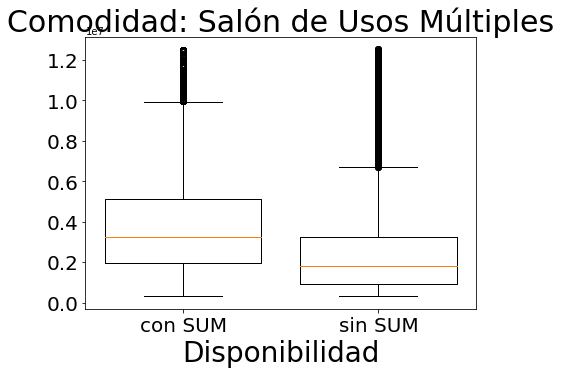

In [24]:
print('Media del precio de las propiedades con SUM $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin SUM $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio'].mean()))

fig_2 = plt.figure(1, figsize = (7,5))
sub_fig = fig_2.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Comodidad: Salón de Usos Múltiples", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'], 
                            df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio']],
                           labels = ['con SUM', 'sin SUM'],
                           widths = 0.8)

Media del precio de las propiedades con piscina $ 3315052
Media del precio de las propiedades sin piscina $ 2455453



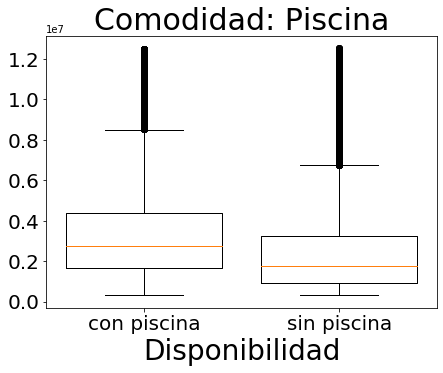

In [25]:
print('Media del precio de las propiedades con piscina $ {:.0f}'
      .format(df_abool.loc[df_abool['TienePileta'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin piscina $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TienePileta'] == False]['Precio'].mean()))

fig_3 = plt.figure(1, figsize = (7,5))
sub_fig = fig_3.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Comodidad: Piscina", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TienePileta'] == True]['Precio'],
                            df_abool.loc[df_abool['TienePileta'] == False]['Precio']],
                           labels = ['con piscina', 'sin piscina'],
                           widths = 0.8)

Media del precio de las propiedades con escuelas cercanas $ 2533456
Media del precio de las propiedades sin escuelas cercanas $ 2528336



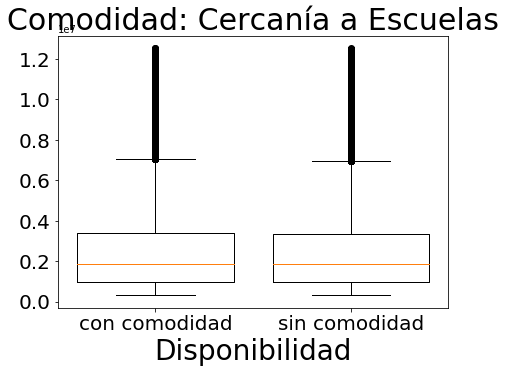

In [26]:
print('Media del precio de las propiedades con escuelas cercanas $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin escuelas cercanas $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio'].mean()))

fig_4 = plt.figure(1, figsize = (7,5))
sub_fig = fig_4.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Comodidad: Cercanía a Escuelas", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'],
                            df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio']],
                           labels = ['con comodidad', 'sin comodidad'],
                           widths = 0.8)

Media del precio de las propiedades con centros comerciales cencanos $ 2605484
Media del precio de las propiedades sin centros comerciales cencanos $ 2481294



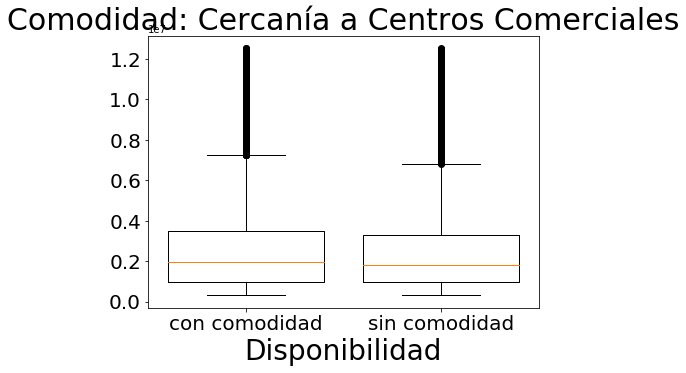

In [27]:
print('Media del precio de las propiedades con centros comerciales cencanos $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin centros comerciales cencanos $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio'].mean()))

fig_5 = plt.figure(1, figsize = (7,5))
sub_fig = fig_5.add_subplot(111)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Comodidad: Cercanía a Centros Comerciales", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'],
                            df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio']],
                           labels = ['con comodidad', 'sin comodidad'],
                           widths = 0.8)

In [28]:
# Se arman DataFrames con comodidades exclusivas para las propiedades.
# Las escuelas y los centros comerciales no se consideran exclusivos para una propiedad.
solo_gimnasio = df_abool.loc[(df_abool['TieneGimnasio'] == True) & 
                             (df_abool['TieneUsosMultiples'] == False) & 
                             (df_abool['TienePileta'] == False)].copy()

solo_sum = df_abool.loc[(df_abool['TieneGimnasio'] == False) & 
                        (df_abool['TieneUsosMultiples'] == True) & 
                        (df_abool['TienePileta'] == False)].copy()

solo_piscina = df_abool.loc[(df_abool['TieneGimnasio'] == False) & 
                            (df_abool['TieneUsosMultiples'] == False) & 
                            (df_abool['TienePileta'] == True)].copy()

In [29]:
# Solo con SUM

print('Media del precio de las propiedades con solo Gimnasio $ {:.0f}'
      .format(solo_gimnasio['Precio'].mean()))

print('Media del precio de las propiedades con solo SUM $ {:.0f}'
      .format(solo_sum['Precio'].mean()))

print('Media del precio de las propiedades con solo Piscina $ {:.0f}'
      .format(solo_piscina['Precio'].mean()))

Media del precio de las propiedades con solo Gimnasio $ 3056434
Media del precio de las propiedades con solo SUM $ 3593696
Media del precio de las propiedades con solo Piscina $ 2719016


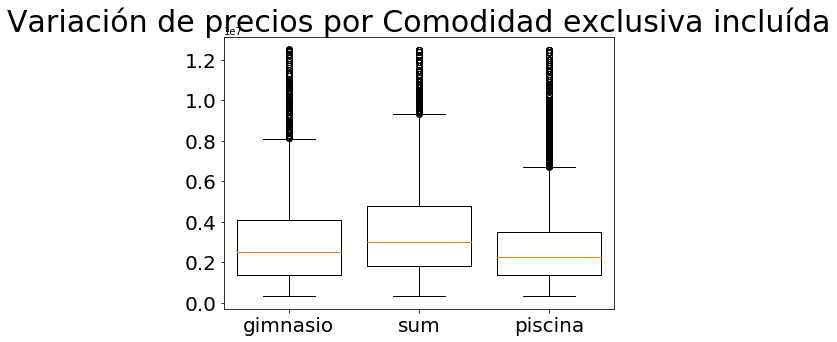

In [30]:
# Análisis por exclusión de las distintas comodidades
plt.figure(figsize = (7,5))
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
# Para formatear los ejes
#sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Variación de precios por Comodidad exclusiva incluída", fontsize = 30)
box_plot = plt.boxplot([solo_gimnasio['Precio'], solo_sum['Precio'], solo_piscina['Precio']], \
                       labels = ['gimnasio', 'sum','piscina'], \
                       widths = 0.8)

### Primero armo una lista de nombres de las provincias ordenadas por la media del precio de las propiedades

In [31]:
propiedades_valores = df_abool[['Provincia', 'Precio']].copy()

In [32]:
# Se verifica si hay valores nulos
print(propiedades_valores.isnull().sum())

Provincia    0
Precio       0
dtype: int64


In [33]:
propiedades_valores = propiedades_valores.groupby(['Provincia']).agg({'Precio':'mean'}).copy()
# Se le cambia el nombre a la columna
propiedades_valores.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
# Se le cambia el tipo a la columna
propiedades_valores['Media Precio'] = propiedades_valores['Media Precio'].astype(np.uint32).copy()
propiedades_valores.head(1)

,Media Precio
Provincia,
Aguascalientes,1477188


In [34]:
# Ordeno de mayor a menor por Media de precio
propiedades_valores = propiedades_valores.sort_values(by='Media Precio', ascending = False)
propiedades_valores.head()

,Media Precio
Provincia,
Distrito Federal,3471126
Edo. de México,2762169
Nuevo León,2715694
Guerrero,2550175
Quintana Roo,2402542


In [35]:
# Arreglo los índices
propiedades_valores.reset_index(inplace=True)
propiedades_valores.head()

,Provincia,Media Precio
0,Distrito Federal,3471126
1,Edo. de México,2762169
2,Nuevo León,2715694
3,Guerrero,2550175
4,Quintana Roo,2402542


In [36]:
# Se arma una lista con los nombres de las provincias en orden alfabético
provincias_nombres = propiedades_valores['Provincia'].unique()
provincias_nombres = list(provincias_nombres) # Convierte nunpy.array en lista

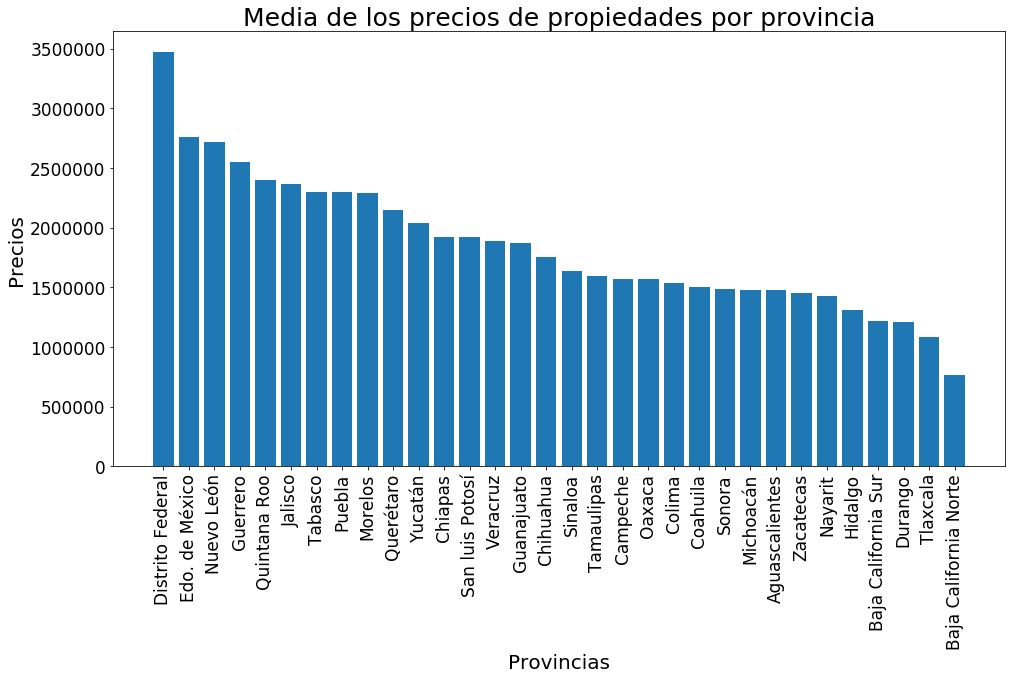

In [37]:
# Gráfico de media de precio por provincia
indice = propiedades_valores['Provincia']
media = propiedades_valores['Media Precio']
ancho = 0.8

plt.figure(figsize = (16,8))
plt.bar(indice, media, ancho)
plt.title("Media de los precios de propiedades por provincia", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [38]:
# Ahora con solo gimnasios

# Se crea una lista de los nombres de las provincias ordenados de mayor a menor por la media
provincias_nombres = solo_gimnasio\
    .groupby(['Provincia'])\
    .agg({'Precio' : 'mean'})\
    .sort_values(by = 'Precio', ascending = False)
provincias_nombres.rename(columns = {'Precio' : 'Media'}, inplace = True) # Se renombra por claridad
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.uint32)
provincias_nombres.reset_index(inplace = True)
provincias_nombres = provincias_nombres['Provincia'].unique() 
# Lo anterior devuelve una arrary de categóricos en el orden que aparecen. Se convierte en lista.
provincias_nombres = list(provincias_nombres)

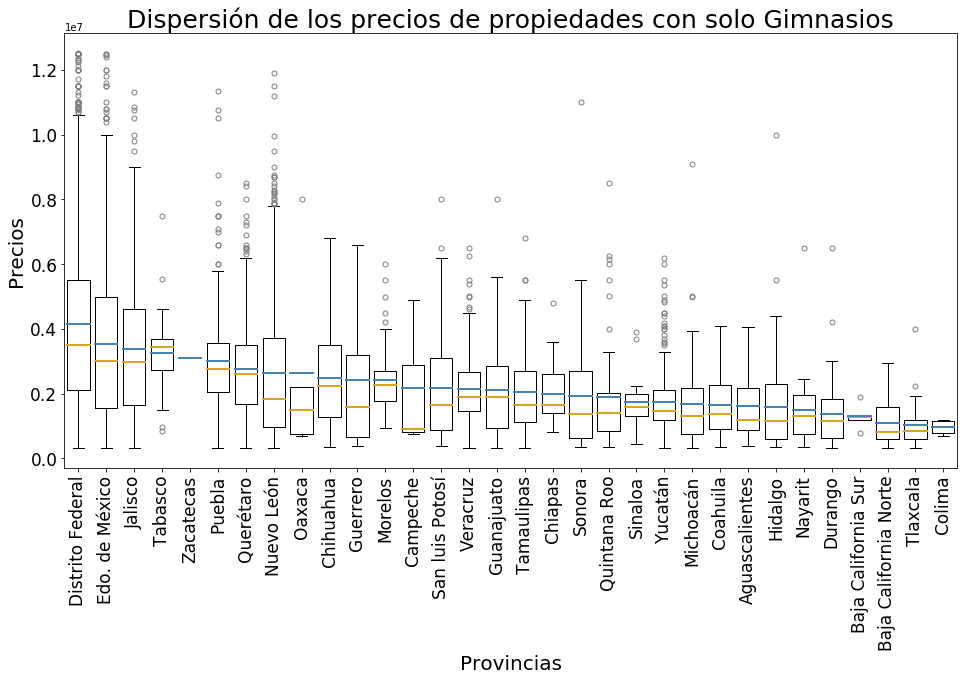

In [39]:
# Gráfico para solo propiedades con gimnasio (exclusivamente)

plt.figure(figsize = (16,8))
plt.boxplot([solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[0]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[1]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[2]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[3]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[4]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[5]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[6]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[7]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[8]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[9]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[10]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[11]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[12]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[13]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[14]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[15]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[16]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[17]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[18]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[19]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[20]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[21]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[22]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[23]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[24]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[25]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[26]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[27]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[28]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[29]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[30]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[31]]['Precio']], \
            labels = provincias_nombres, \
            widths = 0.8, \
            meanline = True, showmeans = True, \
            boxprops = dict(linewidth=1), \
            meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
            # linestyle = '-' muestra la media con línea sólida
            flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'grey'), \
            medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.title("Dispersión de los precios de propiedades con solo Gimnasios", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [40]:
# Ahora con solo SUM

# Se crea una lista de los nombres de las provincias ordenados de mayor a menor por la media
provincias_nombres = solo_sum\
    .groupby(['Provincia'])\
    .agg({'Precio' : 'mean'})\
    .sort_values(by = 'Precio', ascending = False)
provincias_nombres.rename(columns = {'Precio' : 'Media'}, inplace = True) # Se renombra por claridad
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.uint32)
provincias_nombres.reset_index(inplace = True)
provincias_nombres = provincias_nombres['Provincia'].unique() 
# Lo anterior devuelve una arrary de categóricos en el orden que aparecen. Se convierte en lista.
provincias_nombres = list(provincias_nombres) 

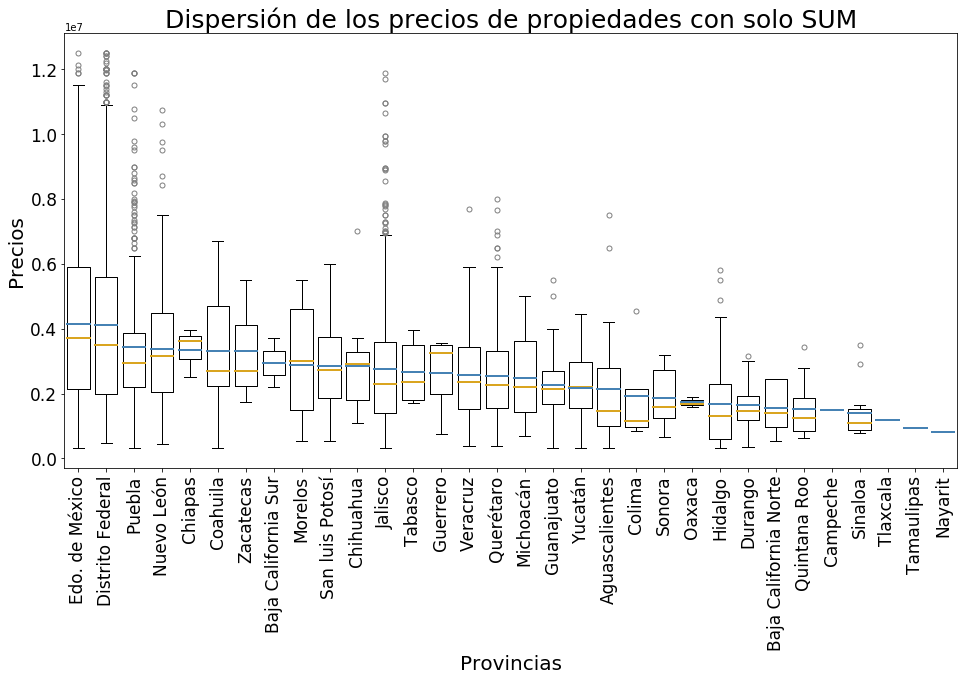

In [41]:
# Gráfico para solo propiedades con Salón de Usos Múltiples (exclusivamente)

plt.figure(figsize = (16,8))
plt.boxplot([solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[0]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[1]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[2]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[3]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[4]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[5]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[6]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[7]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[8]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[9]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[10]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[11]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[12]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[13]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[14]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[15]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[16]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[17]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[18]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[19]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[20]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[21]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[22]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[23]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[24]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[25]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[26]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[27]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[28]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[29]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[30]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[31]]['Precio']], \
            labels = provincias_nombres, \
            widths = 0.8, \
            meanline = True, showmeans = True, \
            boxprops = dict(linewidth=1), \
            meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
            # linestyle = '-' muestra la media con línea sólida
            flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'grey'), \
            medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.title("Dispersión de los precios de propiedades con solo SUM", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [42]:
# Ahora con solo Piletas

# Se crea una lista de los nombres de las provincias ordenados de mayor a menor por la media
provincias_nombres = solo_piscina\
    .groupby(['Provincia'])\
    .agg({'Precio' : 'mean'})\
    .sort_values(by = 'Precio', ascending = False)
provincias_nombres.rename(columns = {'Precio' : 'Media'}, inplace = True)
provincias_nombres.isnull()
# Hay un caso nulo: Zacatecas 

,Media
Provincia,
Distrito Federal,False
Edo. de México,False
Nuevo León,False
Tabasco,False
Quintana Roo,False
Tamaulipas,False
Jalisco,False
Coahuila,False
Puebla,False


In [43]:
print(dfok.loc[dfok['Provincia'] == 'Zacatecas']['TienePileta'].value_counts())

0.0    94
Name: TienePileta, dtype: int64


Un análisis general del DataFrame dfok muestra que solo hay 0.0 ("Falso") en el conteo de casos para la provincia Zacatecas. Esto es que ninguna propiedad tiene pileta en Zacatecas.

In [44]:
# Se elimina la fila con nulos
provincias_nombres.dropna(inplace = True)
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.uint32)
provincias_nombres.reset_index(inplace = True)
provincias_nombres = provincias_nombres['Provincia'].unique()
# Lo anterior devuelve una arrary de categóricos en el orden que aparecen. Se convierte en lista.
provincias_nombres = list(provincias_nombres)
# Ahora la lista de nombres de provincias no tiene casos nulos

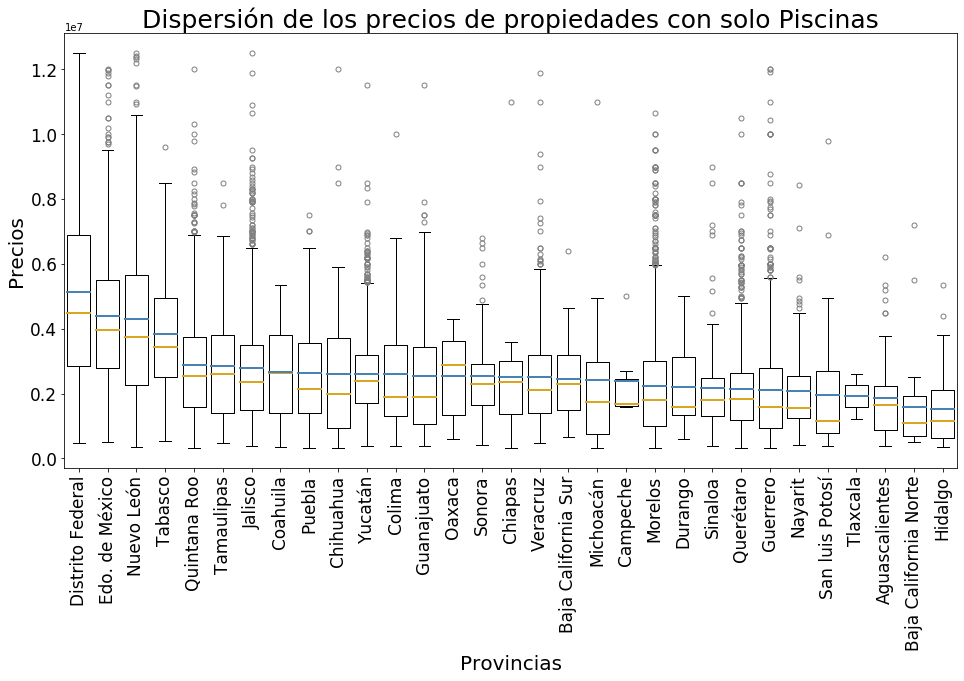

In [45]:
# Gráfico para solo propiedades con Pileta (exclusivamente)

plt.figure(figsize = (16,8))
plt.boxplot([solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[0]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[1]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[2]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[3]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[4]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[5]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[6]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[7]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[8]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[9]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[10]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[11]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[12]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[13]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[14]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[15]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[16]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[17]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[18]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[19]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[20]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[21]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[22]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[23]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[24]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[25]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[26]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[27]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[28]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[29]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[30]]['Precio']], \
            labels = provincias_nombres, \
            widths = 0.8, \
            meanline = True, showmeans = True, \
            boxprops = dict(linewidth=1), \
            meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
            # linestyle = '-' muestra la media con línea sólida
            flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'grey'), \
            medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.title("Dispersión de los precios de propiedades con solo Piscinas", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

# Análisis de tipo de comodidad a medida que pasan los años

In [70]:
# Se usa df_ok para las columnas porque tiene números en las columnas, sirve para contar.
df_comodidad = dfok[['TieneGimnasio', \
                     'TieneUsosMultiples', \
                     'TienePileta', \
                     'TieneEscuelasCerca', \
                     'TieneShoppingsCerca']]
# Aquí se usa dfok pues tiene la columna 'Antiguedad'
df_comodidad.insert(0, 'Antiguedad', dfok['Antiguedad'])

### Analizo si hay nulos

In [71]:
print(df_comodidad.isnull().sum())
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Antiguedad             43555
TieneGimnasio              0
TieneUsosMultiples         0
TienePileta                0
TieneEscuelasCerca         0
TieneShoppingsCerca        0
dtype: int64
Memoria usada 10.99 MB


Hay 43555 casos nulos y es necesario rmoverlos para covertir los tipos. Hasta aquí los tipos del DataFrame df_comodidad son float64.

In [72]:
# Elimino las filas nulas, para así poder realizar las conversión de tipos.
# Además, para este análisis es necesario un valor en la columna 'Antiguedad'.
df_comodidad = df_comodidad.dropna().copy()
df_comodidad.reset_index(drop = True, inplace = True)
df_comodidad.dtypes

Antiguedad             float64
TieneGimnasio          float64
TieneUsosMultiples     float64
TienePileta            float64
TieneEscuelasCerca     float64
TieneShoppingsCerca    float64
dtype: object

In [73]:
# Cambio los tipos del DataFrame
df_comodidad['Antiguedad'] = df_comodidad['Antiguedad'].astype(np.uint8)
df_comodidad['TieneGimnasio'] = df_comodidad['TieneGimnasio'].astype(np.uint8)
df_comodidad['TieneUsosMultiples'] = df_comodidad['TieneUsosMultiples'].astype(np.uint8)
df_comodidad['TienePileta'] = df_comodidad['TienePileta'].astype(np.uint8)
df_comodidad['TieneEscuelasCerca'] = df_comodidad['TieneEscuelasCerca'].astype(np.uint8)
df_comodidad['TieneShoppingsCerca'] = df_comodidad['TieneShoppingsCerca'].astype(np.uint8)
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Memoria usada 1.12 MB


Como se tienen 80 años para antigüedad, agregro una columna con rango de años.

In [50]:
# Se define una función de calcula el rango de años dónde cae la antigüedad de la propiedad
# Primero se elige un orden y luego se cambia el nombre de las filas.
# Esto es para evitar tener que insrtar una fila en medio del DataFrame
def rango_de_años(df):
    if df['Antiguedad'] <= 5: return '00'# '0 - 5'
    elif 6  <= df['Antiguedad'] <= 10: return '01'# '6 - 10'
    elif 11 <= df['Antiguedad'] <= 15: return '02'# '11 - 15'
    elif 16 <= df['Antiguedad'] <= 20: return '03'# '16 - 20'
    elif 21 <= df['Antiguedad'] <= 25: return '04'# '21 - 25'
    elif 26 <= df['Antiguedad'] <= 30: return '05'# '26 - 30'
    elif 31 <= df['Antiguedad'] <= 35: return '06'# '31 - 35'
    elif 36 <= df['Antiguedad'] <= 40: return '07'# '26 - 40'
    elif 41 <= df['Antiguedad'] <= 45: return '08'# '41 - 45'
    elif 46 <= df['Antiguedad'] <= 50: return '09'# '46 - 50'
    elif 51 <= df['Antiguedad'] <= 55: return '10'# '51 - 55'
    elif 56 <= df['Antiguedad'] <= 60: return '11'# '56 - 60'
    elif 61 <= df['Antiguedad'] <= 65: return '12'# '61 - 65'
    elif 66 <= df['Antiguedad'] <= 70: return '13'# '66 - 70'
    elif 71 <= df['Antiguedad'] <= 75: return '14'# '71 - 75'
    elif 76 <= df['Antiguedad'] <= 80: return '15'# '76 - 80'

In [77]:
# Auxiliar para asignar rango de años
df_aux = df_comodidad.apply(rango_de_años, axis = 1) # Devuelve una serie

In [79]:
# Se hace una copia para los agrupados
df_comodidad_agrupada = df_comodidad.copy()

In [80]:
# Se agrega la columna correspondiente al rango de años de antigüedad
df_comodidad_agrupada['RangoDeAños'] = df_aux

In [84]:
# Se usa el auxiliar para agrupar por rango de años
df_aux = df_comodidad_agrupada.groupby('RangoDeAños').agg({'TieneGimnasio':'sum', \
                                        'TieneUsosMultiples':'sum', \
                                        'TienePileta':'sum', \
                                        'TieneEscuelasCerca':'sum', \
                                        'TieneShoppingsCerca':'sum'})
# Aquí df_aux no toma en cuenta la columna Antigüedad

In [85]:
df_comodidad_agrupada = df_aux.copy()

In [86]:
# Ahora se cambia el nombre de las filas del índice RangoDeAños
dictionary = {'00':'0 - 5', '01':'6 - 10', '02':'11 - 15', '03':'16 - 20', \
             '04':'21 - 25', '05':'26 - 30', '06':'31 - 35', '07':'36 - 40', \
             '08':'41 - 45', '09':'46 - 50', '10':'51 - 55', '11':'56 - 60', \
             '12':'61 - 65', '13':'66 - 70', '14':'71 - 75', '15':'76 - 80'}
df_comodidad_agrupada.rename(dictionary, axis=0, inplace=True)

In [87]:
df_comodidad_agrupada

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
RangoDeAños,,,,,
0 - 5,10782.0,9652.0,15573.0,58159.0,52386.0
6 - 10,1659.0,1498.0,2236.0,20149.0,18271.0
11 - 15,314.0,218.0,457.0,3610.0,2841.0
16 - 20,544.0,671.0,697.0,12406.0,11514.0
21 - 25,162.0,78.0,138.0,1758.0,1343.0
26 - 30,62.0,85.0,105.0,1834.0,1494.0
31 - 35,15.0,37.0,31.0,652.0,493.0
36 - 40,14.0,19.0,28.0,680.0,527.0
41 - 45,1.0,5.0,4.0,187.0,140.0


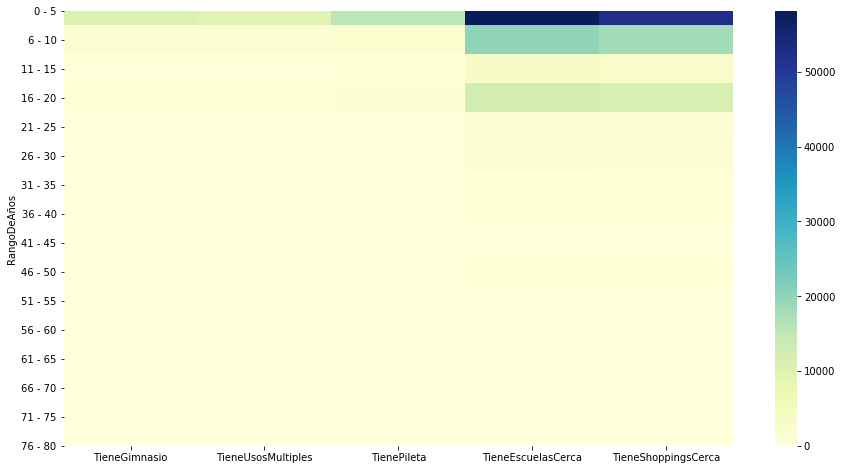

In [88]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada,cmap = 'YlGnBu', cbar = True)

Se ve que en las propiedades antiguas no hay suficiente cantidad de comodidades como para poder apreciarlas en el gráfico

In [89]:
# Si se toman propiedades con hasta 20 años de antigüedad se tiene lo siguiente
df_comodidad_agrupada[0:4]

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
RangoDeAños,,,,,
0 - 5,10782.0,9652.0,15573.0,58159.0,52386.0
6 - 10,1659.0,1498.0,2236.0,20149.0,18271.0
11 - 15,314.0,218.0,457.0,3610.0,2841.0
16 - 20,544.0,671.0,697.0,12406.0,11514.0


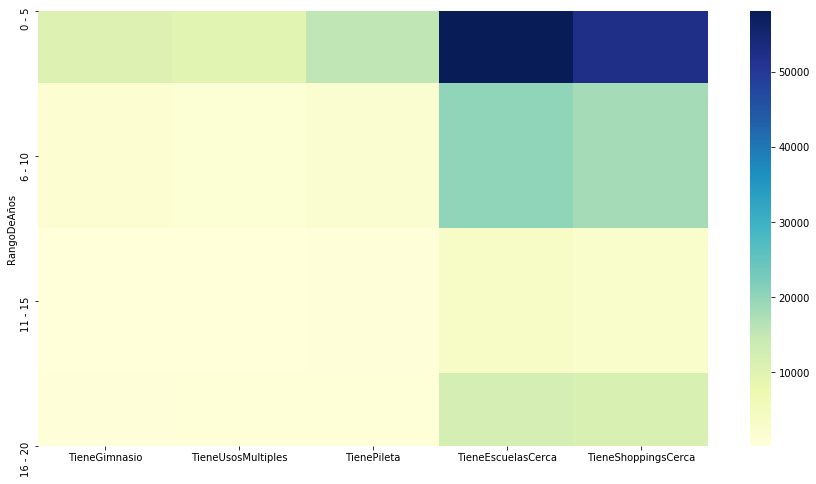

In [90]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada[0:4], cmap = 'YlGnBu', cbar = True)

In [91]:
df_comodidad_agrupada.columns

Index(['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta',
       'TieneEscuelasCerca', 'TieneShoppingsCerca'],
      dtype='object')

In [92]:
# Si se descartan las columnas TieneEscuelasCerca y TieneShoppingsCerca se tiene
df_comodidad_agrupada[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:4]

,TieneGimnasio,TieneUsosMultiples,TienePileta
RangoDeAños,,,
0 - 5,10782.0,9652.0,15573.0
6 - 10,1659.0,1498.0,2236.0
11 - 15,314.0,218.0,457.0
16 - 20,544.0,671.0,697.0


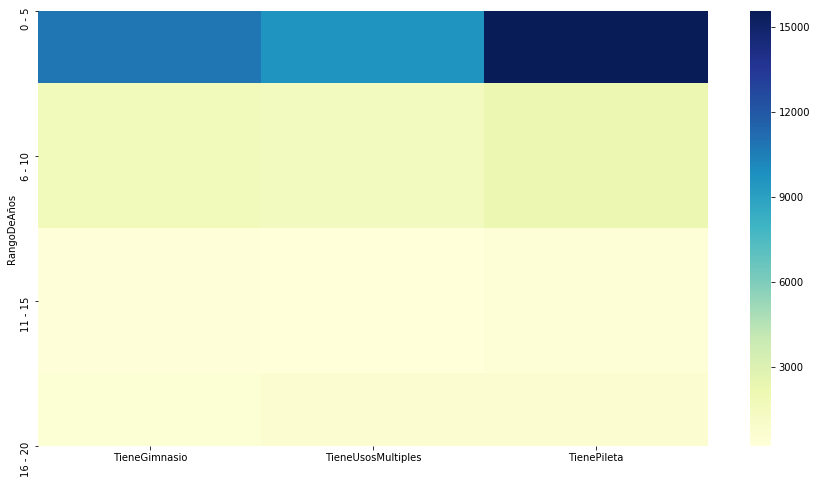

In [94]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:4], \
                  cmap = 'YlGnBu', cbar = True)